# Overfit-generalization-underfit

In the previous notebook, we presented the general cross-validation framework
and how it helps us **quantify the training and test errors** as well
as their variance.

In this notebook, we put these two errors into perspective and show how
they can help us **learn if the model generalizes, overfit, or underfit** by **tuning a hyperparameter** and **plotting a validation curve**.

Let's first load the data and create the same model as in the previous
notebook.

In [7]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [8]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

## Overfitting vs. underfitting

To **better understand the statistical performance of our model** and maybe find
insights on how to improve it, we **compare the test error with the
training error**. Thus, we need to compute the error on the training set,
which is possible using the **`cross_validate`** function.

In [9]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

The cross-validation used the **negative mean absolute error**. We transform
the negative mean absolute error into a **positive mean absolute error**.

In [10]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]
scores.head()

,train error,test error
0,1.170812e-14,46.058152
1,3.011372e-15,46.098077
2,6.816253e-15,46.669593
3,7.515091e-15,46.157474
4,1.124682e-14,45.992967


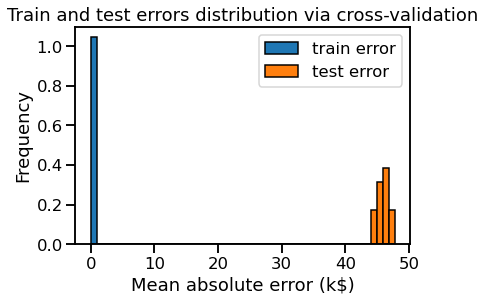

In [11]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

By **plotting the distribution of the training and test errors**, we
get information about **whether our model is over-fitting or under-fitting** (or
both at the same time).

Here, we observe a **small training error** (actually zero), meaning that
the model is **not under-fitting**: it is flexible enough to capture any
variations present in the training set.

However the **significantly larger testing error** tells us that the
model is **over-fitting**: the model has memorized many variations of the
training set that could be considered "noisy" because they do not generalize
to help us make good prediction on the test set.

## Validation curve

Some **model hyperparameters** are usually the key to **go from** a model that
**underfits to** a model that **overfits**, hopefully going through a **region** where we
can get a **good balance between the two**. We can acquire knowledge by **plotting**
a curve called the **validation curve**. This curve can also be applied to the
above experiment and varies the value of a hyperparameter.

For the **decision tree**, the **`max_depth` parameter** is used to **control** the
tradeoff between under-fitting and over-fitting.

In [12]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 153 ms, sys: 30 ms, total: 184 ms
Wall time: 9.77 s


In [16]:
print(test_errors)

[[75.65207176 74.92947488 75.24852418 74.34740317 73.12785109 76.53229253
  74.64779343 73.64628377 75.6590593  74.80885583 75.45107045 73.24278228
  75.18984863 74.78852185 74.2634483  75.39402069 74.24186289 75.47905882
  73.0742395  74.68664131 75.23441753 74.22351445 75.55245433 73.44283806
  74.60074693 75.21801486 73.38972899 74.68637626 75.40946432 74.51536516]
 [52.41328265 51.46994951 52.21667264 51.11120774 51.16130364 52.67397309
  53.05935964 52.01699522 52.80987697 52.69032277 52.95448141 51.9164004
  54.02480685 51.69749254 51.32726078 52.85646444 53.35470341 52.28402693
  51.84988502 52.3138221  52.0948656  52.5325895  53.25242268 51.75246736
  51.90235452 51.75009062 50.95569638 52.34973781 53.59318853 52.43548329]
 [41.45124814 42.0112495  41.83979406 41.86674497 42.19049264 43.12302767
  44.18116465 42.68305624 42.38086793 42.18576824 43.19109184 42.66297819
  42.09595432 42.60807873 41.55330247 43.40470458 43.30464953 41.56486058
  41.50265359 42.96718748 42.71543057

Now that we collected the results, we will show the **validation curve** by
**plotting the training and testing errors** (as well as their deviations).

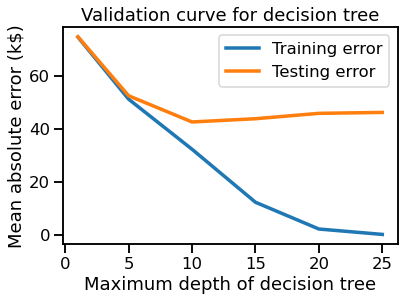

In [7]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

The **validation curve** can be divided into **three regions**:

- For **`max_depth < 10`**, the decision tree **underfits**. The **training error** and
  therefore the testing error are both **high**. The **model** is **too
  constrained** and cannot capture much of the variability of the target
  variable.

- The region around **`max_depth = 10`** corresponds to the parameter for which
  the **decision tree generalizes the best**. It is **flexible enough to capture a
  fraction of the variability of the target that generalizes**, while **not
  memorizing all of the noise in the target**.

- For **`max_depth > 10`**, the decision tree **overfits**. The **training error**
  becomes very **small**, while the **test error increases**. In this
  region, the models create decisions specifically for noisy samples harming
  its ability to generalize to test data.

Note that for **`max_depth = 10`**, the **model overfits a bit** as there is a **gap
between the training error and the test error**. It can also
**potentially underfit also** a bit at the same time, because the **training error
is still far from zero** (more than \\$30k), meaning that the model might
still be too constrained to model interesting parts of the data. However, the
**test error is at its minimum**, and this is what really matters. This is the
**best compromise** we could reach by just **tuning this parameter**.

Be aware that looking at the **mean errors** is quite limiting. We should also
look at the **standard deviation** to assess the dispersion of the score. We
can repeat the same plot as before but this time, we will add some
information to show the standard deviation of the errors as well.

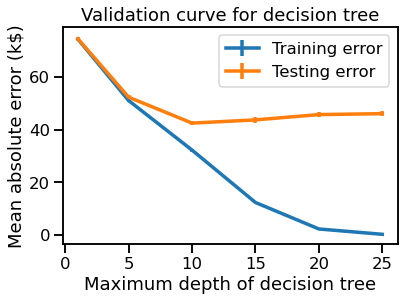

In [8]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

We are lucky that the **variance of the errors is small** compared to their
respective values, and therefore the conclusions above are quite clear. This
is not necessarily always the case.

## Summary:

In this notebook, we saw:

* how to identify whether a model is **generalizing**, overfitting, or
  underfitting;
* how to check **influence of a hyperparameter** on the **tradeoff
  underfit/overfit**.